In [1]:
import os
import shutil
import subprocess
import numpy as np
import pandas as pd
import flopy
import pyemu
import lumpyrem as lr
from lumpyrem import run
from lumpyrem.lr2series import TimeSeries
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})

In [2]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

c:\users\nat12nho\appdata\local\programs\python\python38\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
bins_pth = os.path.join('..', 'bins', 'win') if 'nt' in os.name else os.path.join('..', 'bins', 'linux') # Binaries

In [4]:
lr_ws = os.path.join('..', 'temp_lr_prep') # Lumprem model workspace.  Safe to delete.

In [5]:
lumprem_input_pth = os.path.join('..', 'data', 'lumprem_input') # Input data curated in a previous notebook
os.listdir(lumprem_input_pth)

['evapot.dat', 'rainfall.dat']

In [6]:
if os.path.exists(lr_ws):
    shutil.rmtree(lr_ws)
os.mkdir(lr_ws)

In [7]:
for file in os.listdir(lumprem_input_pth):
    shutil.copyfile(lumprem_input_pth+'\\'+file, lr_ws+'\\'+file) #Works for Windows. Does it work for Linux?

In [8]:
os.listdir(lr_ws)

['evapot.dat', 'rainfall.dat']

## Setup recharge model
What about EVT?

In [9]:
# initiate the model and write the in files. What about rbuf & mbuf?
# landuse model for recharge, evap
lr_lu1 = lr.lumprem.Model(
    model_name = 'lu1',
    workspace = lr_ws,
    irrigvolfrac = 0.0,
    rainfile = 'rainfall.dat',
    epotfile = 'evapot.dat',
    maxvol = 0.5, # Varför valde jag 0.2 istället för 0.5 som är default?
    vol = 0.1,
    ks = 43.2 # 43.2 m/day = 0.0005 m/s ≈ reasonable initial guess considering local geology
)

In [10]:
lr_lu1.write_model(
    start_date = '31/12/2015',
    ssf_start_date = '01/01/16',
    end_date = '01/01/2020',
    noutdays='monthly',
    mxiter = 500,
    ssf_var = [['ks', 'lr_lu1', 1.0, 0.0, 8.640E-04, 8640]], # Does this do anything?
)
lr_lu1.run_model(version=2)

LUMPREM model input file written to: 
..\temp_lr_prep\lr_lu1.in
PEST template file written to: 
..\temp_lr_prep\lr_lu1.tpl

 Enter name of LUMPREM input file:  Enter name for LUMPREM tabular output file:  Enter name for CSV output file (<Enter> if none):  
 - file lr_lu1.in read ok.
 - file lumprem_variables.rec written ok.
 - file rainfall.dat read ok.
 - file evapot.dat read ok.
 - file lr_lu1.out written ok.
 - file lr_lu1.csv written ok.



In [11]:
# get model results
results = lr_lu1.get_results()
display(results.head())

,days,vol_upper,vol_lower,vol_drain,vol_macro,del_vol_upper,del_vol_lower,del_vol_drain,del_vol_macro,rainfall,...,workspace,maxvol_br,extravol_br,gamma_br,ks_br,m_br,l_br,vol_br,epotfile_br,epot_br_all
0,0,0.100000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0000,...,..\temp_lr_prep,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,0.095470,0.0,0.007108,0.0,-0.004530,0.0,0.007108,0.0,0.0026,...,..\temp_lr_prep,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,32,0.072635,0.0,0.009215,0.0,-0.022835,0.0,0.002107,0.0,0.0365,...,..\temp_lr_prep,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,61,0.058014,0.0,0.003891,0.0,-0.014621,0.0,-0.005323,0.0,0.0261,...,..\temp_lr_prep,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,92,0.064780,0.0,0.004798,0.0,0.006766,0.0,0.000907,0.0,0.0354,...,..\temp_lr_prep,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
display(results.tail())

,days,vol_upper,vol_lower,vol_drain,vol_macro,del_vol_upper,del_vol_lower,del_vol_drain,del_vol_macro,rainfall,...,workspace,maxvol_br,extravol_br,gamma_br,ks_br,m_br,l_br,vol_br,epotfile_br,epot_br_all
45,1340,0.082864,0.0,0.014162,0.0,0.011091,0.0,0.004988,0.0,0.1140,...,..\temp_lr_prep,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
46,1370,0.079398,0.0,0.011386,0.0,-0.003466,0.0,-0.002777,0.0,0.0992,...,..\temp_lr_prep,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47,1401,0.065671,0.0,0.007355,0.0,-0.013727,0.0,-0.004030,0.0,0.0659,...,..\temp_lr_prep,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
48,1431,0.078073,0.0,0.018819,0.0,0.012402,0.0,0.011464,0.0,0.0731,...,..\temp_lr_prep,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
49,1462,0.065583,0.0,0.007138,0.0,-0.012490,0.0,-0.011681,0.0,0.0654,...,..\temp_lr_prep,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
display(results.columns)

Index(['days', 'vol_upper', 'vol_lower', 'vol_drain', 'vol_macro',
       'del_vol_upper', 'del_vol_lower', 'del_vol_drain', 'del_vol_macro',
       'rainfall', 'irrigation', 'drain_upper', 'macro_upper', 'drain_lower',
       'overflow_lower', 'total_rech', 'gw_withdrawal', 'net_recharge',
       'runoff', 'pot_evap_upper', 'evap_upper', 'pot_evap_lower',
       'evap_lower', 'gw_pot_evap', 'balance', 'elevation', 'depth-to-water',
       'lumprem_model_name', 'rainfile', 'epotfile', 'vegfile', 'irrigfile',
       'maxvol', 'irrigvolfrac', 'rdelay', 'mdelay', 'ks', 'M', 'L',
       'mflowmax', 'offset', 'factor1', 'factor2', 'power', 'elevmin',
       'elevmax', 'surface', 'vol', 'workspace', 'maxvol_br', 'extravol_br',
       'gamma_br', 'ks_br', 'm_br', 'l_br', 'vol_br', 'epotfile_br',
       'epot_br_all'],
      dtype='object')

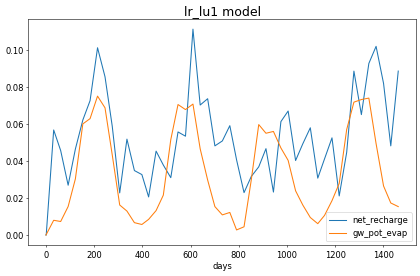

In [14]:
fig = plt.figure(figsize=(10, 6), dpi=50)
ax = fig.add_subplot(1, 1, 1)
plt.ticklabel_format(axis='both', style='plain', useOffset=False) #Show coordinates
ax.set_title('lr_lu1 model', fontsize=18)

results.plot('days','net_recharge', ax=ax)
results.plot('days', 'gw_pot_evap', ax=ax)

plt.legend()
plt.show()

## Setup GHB models

GHB Models:

In [15]:
initial_ghb_bheads = {
    'red': 142.5,
    'orange': 142.0,
    'yellow': 141.,
    'limegreen': 139.5,
    'royalblue': 135.,
    'blueviolet': 137.5,
    'magenta': 139.5,
}

In [16]:
lr_ghb_red = lr.lumprem.Model(
    model_name = 'red',
    workspace = lr_ws,
    factor1 = 30,
    factor2 = 20,
    power = 2,
    offset = initial_ghb_bheads['red'],
    maxvol = 0.5,
    vol = 0.08,
    surface = 200,
    ks = 43.2,
    irrigvolfrac=0.0,
    rainfile = 'rainfall.dat',
    epotfile = 'evapot.dat',
)

In [17]:
lr_ghb_orange = lr.lumprem.Model(
    model_name = 'orange',
    workspace = lr_ws,
    factor1 = 30,
    factor2 = 20,
    power = 2,
    offset = initial_ghb_bheads['orange'],
    maxvol = 0.5,
    vol = 0.08,
    surface = 200,
    ks = 43.2,
    irrigvolfrac=0.0,
    rainfile = 'rainfall.dat',
    epotfile = 'evapot.dat',
)

In [18]:
lr_ghb_yellow = lr.lumprem.Model(
    model_name = 'yellow',
    workspace = lr_ws,
    factor1 = 30,
    factor2 = 20,
    power = 2,
    offset = initial_ghb_bheads['yellow'],
    maxvol = 0.5,
    vol = 0.08,
    surface = 200,
    ks = 43.2,
    irrigvolfrac=0.0,
    rainfile = 'rainfall.dat',
    epotfile = 'evapot.dat',
)

In [19]:
lr_ghb_limegreen = lr.lumprem.Model(
    model_name = 'limegreen',
    workspace = lr_ws,
    factor1 = 30,
    factor2 = 20,
    power = 2,
    offset = initial_ghb_bheads['limegreen'],
    maxvol = 0.5,
    vol = 0.08,
    surface = 200,
    ks = 43.2,
    irrigvolfrac=0.0,
    rainfile = 'rainfall.dat',
    epotfile = 'evapot.dat',
)

In [20]:
lr_ghb_royalblue = lr.lumprem.Model(
    model_name = 'royalblue',
    workspace = lr_ws,
    factor1 = 30,
    factor2 = 20,
    power = 2,
    offset = initial_ghb_bheads['royalblue'],
    maxvol = 0.5,
    vol = 0.08,
    surface = 200,
    ks = 43.2,
    irrigvolfrac=0.0,
    rainfile = 'rainfall.dat',
    epotfile = 'evapot.dat',
)

In [21]:
lr_ghb_blueviolet = lr.lumprem.Model(
    model_name = 'blueviolet',
    workspace = lr_ws,
    factor1 = 30,
    factor2 = 20,
    power = 2,
    offset = initial_ghb_bheads['blueviolet'],
    maxvol = 0.5,
    vol = 0.08,
    surface = 200,
    ks = 43.2,
    irrigvolfrac=0.0,
    rainfile = 'rainfall.dat',
    epotfile = 'evapot.dat',
)

In [22]:
lr_ghb_magenta = lr.lumprem.Model(
    model_name = 'magenta',
    workspace = lr_ws,
    factor1 = 30,
    factor2 = 20,
    power = 2,
    offset = initial_ghb_bheads['magenta'],
    maxvol = 0.5,
    vol = 0.08,
    surface = 200,
    ks = 43.2,
    irrigvolfrac=0.0,
    rainfile = 'rainfall.dat',
    epotfile = 'evapot.dat',
)

In [23]:
ghb_models = [lr_ghb_red, lr_ghb_orange, lr_ghb_yellow, lr_ghb_limegreen, lr_ghb_royalblue, lr_ghb_blueviolet, lr_ghb_magenta]
for model in ghb_models:
    model.write_model(
        start_date = '31/12/2015',
        ssf_start_date = '01/01/16',
        end_date = '01/01/2020',
        noutdays='monthly',
        mxiter = 500,
    )
    model.run_model(version=2)

LUMPREM model input file written to: 
..\temp_lr_prep\lr_red.in
PEST template file written to: 
..\temp_lr_prep\lr_red.tpl

 Enter name of LUMPREM input file:  Enter name for LUMPREM tabular output file:  Enter name for CSV output file (<Enter> if none):  
 - file lr_red.in read ok.
 - file lumprem_variables.rec written ok.
 - file rainfall.dat read ok.
 - file evapot.dat read ok.
 - file lr_red.out written ok.
 - file lr_red.csv written ok.

LUMPREM model input file written to: 
..\temp_lr_prep\lr_orange.in
PEST template file written to: 
..\temp_lr_prep\lr_orange.tpl

 Enter name of LUMPREM input file:  Enter name for LUMPREM tabular output file:  Enter name for CSV output file (<Enter> if none):  
 - file lr_orange.in read ok.
 - file lumprem_variables.rec written ok.
 - file rainfall.dat read ok.
 - file evapot.dat read ok.
 - file lr_orange.out written ok.
 - file lr_orange.csv written ok.

LUMPREM model input file written to: 
..\temp_lr_prep\lr_yellow.in
PEST template file writt

In [24]:
lr_ghb_red_df = lr_ghb_red.get_results()

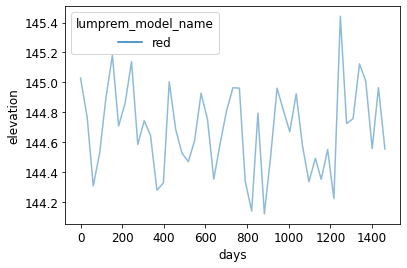

In [25]:
# plot the model results
import seaborn as sb
sb.lineplot(data=lr_ghb_red_df, x='days',y='elevation', hue='lumprem_model_name', alpha=0.5);

# load the simulation

In [26]:
org_model_ws = os.path.join('..', 'base_model_files')
os.listdir(org_model_ws)

['ghbpp.dat',
 'ghbpp.tpl',
 'hagfors_1.cbb',
 'hagfors_1.disv',
 'hagfors_1.disv.grb',
 'hagfors_1.ghb',
 'hagfors_1.hds',
 'hagfors_1.ic',
 'hagfors_1.ims',
 'hagfors_1.lst',
 'hagfors_1.nam',
 'hagfors_1.npf',
 'hagfors_1.obs',
 'hagfors_1.oc',
 'hagfors_1.rch',
 'hagfors_1.sfr',
 'hagfors_1.sfr.bud',
 'hagfors_1.sfr.obs',
 'hagfors_1.sto',
 'hagfors_1.tdis',
 'head.obs.csv',
 'mfsim.lst',
 'mfsim.nam',
 'sfr_gage.obs.csv',
 'sfr_leak.obs.csv',
 'sfr_pred_leak.obs.csv',
 'sfr_pred_outfr1.obs.csv',
 'sfr_segfile.dat',
 'sfr_stage.obs.csv']

In [27]:
tmp_model_ws = os.path.join('..', 'temp_flopy_lumprem') # Safe to delete
if os.path.exists(tmp_model_ws):
    shutil.rmtree(tmp_model_ws)
shutil.copytree(org_model_ws,tmp_model_ws)
os.listdir(tmp_model_ws)

['ghbpp.dat',
 'ghbpp.tpl',
 'hagfors_1.cbb',
 'hagfors_1.disv',
 'hagfors_1.disv.grb',
 'hagfors_1.ghb',
 'hagfors_1.hds',
 'hagfors_1.ic',
 'hagfors_1.ims',
 'hagfors_1.lst',
 'hagfors_1.nam',
 'hagfors_1.npf',
 'hagfors_1.obs',
 'hagfors_1.oc',
 'hagfors_1.rch',
 'hagfors_1.sfr',
 'hagfors_1.sfr.bud',
 'hagfors_1.sfr.obs',
 'hagfors_1.sto',
 'hagfors_1.tdis',
 'head.obs.csv',
 'mfsim.lst',
 'mfsim.nam',
 'sfr_gage.obs.csv',
 'sfr_leak.obs.csv',
 'sfr_pred_leak.obs.csv',
 'sfr_pred_outfr1.obs.csv',
 'sfr_segfile.dat',
 'sfr_stage.obs.csv']

In [28]:
ml_name = 'hagfors_1'

In [29]:
sim = flopy.mf6.MFSimulation.load(ml_name, 'mf6', os.path.join(bins_pth, 'mf6'), tmp_model_ws)

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package disv...
    loading package ic...
    loading package npf...
    loading package oc...
    loading package sto...
    loading package ghb...
    loading package rch...
    loading package sfr...
    loading package obs...
  loading ims package hagfors_1...


In [30]:
sim.run_simulation()

FloPy is using the following executable to run the model: ..\bins\win\mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.2.1 02/18/2021

   MODFLOW 6 compiled Feb 18 2021 21:14:51 with IFORT compiler (ver. 19.10.3)

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, expressed or 
implied, is made by the USGS or the U.S. Government as to the 
functionality of the software and related material nor shall the 
fact of release constitute any such warranty. Furthermore, the 
software is released on condition that neither the USGS nor the U.S. 
Government shall be held liable for any damages resulting from its 
authorized or unauthorized use. Also refer to the USGS Water 
Resources So

(True, [])

In [31]:
gwf = sim.get_model(ml_name)

In [32]:
disv = gwf.get_package('disv')
rch = gwf.get_package('rch')
ghb = gwf.get_package('ghb')

## Prepare recharge (RCH) timeseries input

In [33]:
rch_ts = lr.lr2series.TimeSeries(
    ts_file='rch.ts',
    workspace=lr_ws,
    lr_models=[lr_lu1],
    ts_names=['rch'],
    lumprem_output_cols=['net_recharge'],
    methods=['linearend'],
    div_delta_t=True
)


In [34]:
rch_ts.write_ts()

MF6 timeseries file ..\temp_lr_prep\rch.ts.in written to:
..\temp_lr_prep\rch.ts.in
 Enter name of LR2SERIES control file:  
 - reading file rch.ts.in...
 
 - reading LUMPREM output file lr_lu1.out...
 - file lr_lu1.out read ok.
 - writing file rch.ts...
 - file rch.ts written ok.
 
 - file rch.ts.in read ok.



### Manipulate RCH ts-file to time-average the first (steady state) output using TS6PROC

In [35]:
def write_script(filename, lines):

    with open(filename, 'a') as f:
        for line in lines:
            f.write(line)
            f.write('\n')

In [36]:
write_script(os.path.join(lr_ws, 'ts6rch.in'), [
'''
# Here is a comment

BEGIN FILES
  FILEIN  rch.ts
  FILEOUT rch_new.ts
END FILES

BEGIN PARAMETERS
END PARAMETERS

BEGIN PROCESSING

  avg = time_average_over_interval(rch_lu1,none,1.0,99999.0)
  
  rch_lu1 = assign_terms(rch_lu1, avg, 0.0, 0.0)

END PROCESSING

'''
])

In [37]:
p = subprocess.run(['ts6proc', 'ts6rch.in'], cwd=lr_ws, stdout=subprocess.PIPE, text=True)
for row in p.stdout.split('\n'):
    print(row)


 TS6PROC Version 1.00. Watermark Numerical Computing.

 - reading file rch.ts...
 - file rch.ts read ok.
 
 Processing: avg = time_average_over_interval(rch_...
 Processing: rch_lu1 = assign_terms(rch_lu1, avg, ...
 
 - writing file rch_new.ts...
 - file rch_new.ts written ok.



Select non-ghb cells (cells can't both be rch and ghb):

In [38]:
#ghb_cell_ids cells in ghb cant be part of rch (will cause fortran error)
ghb_cell_ids = [i[0][1] for i in ghb.stress_period_data.data[0]]

Create rch TS for all non-ghb cells:

In [39]:
rchcells = np.array(list(range(disv.ncpl.data)), dtype=int)
rchcells[ghb_cell_ids] = -1
rch_spd = [
    ((0, rchcells[i]), 'rch_lu1', 1, 'rch') for i in range(disv.ncpl.data) if rchcells[i] > 0
]
rch_spd = {0: rch_spd, 1: rch_spd}

Display the data-structure of the old recharge package:

In [40]:
rch.stress_period_data.data

{0: rec.array([((0, 23), 0.00054795), ((0, 24), 0.00054795),
            ((0, 25), 0.00054795), ..., ((0, 3069), 0.00054795),
            ((0, 3070), 0.00054795), ((0, 3071), 0.00054795)],
           dtype=[('cellid', 'O'), ('recharge', '<f8')]),
 1: rec.array([((0, 23), 0.00054795), ((0, 24), 0.00054795),
            ((0, 25), 0.00054795), ..., ((0, 3069), 0.00054795),
            ((0, 3070), 0.00054795), ((0, 3071), 0.00054795)],
           dtype=[('cellid', 'O'), ('recharge', '<f8')])}

Let's take a more detailed look at one of the stress periods:

In [41]:
rch.stress_period_data.data[0][:10]
# Current data structure is cellid, recharge

rec.array([((0, 23), 0.00054795), ((0, 24), 0.00054795),
           ((0, 25), 0.00054795), ((0, 26), 0.00054795),
           ((0, 27), 0.00054795), ((0, 28), 0.00054795),
           ((0, 29), 0.00054795), ((0, 30), 0.00054795),
           ((0, 31), 0.00054795), ((0, 32), 0.00054795)],
          dtype=[('cellid', 'O'), ('recharge', '<f8')])

Remove old recharge package:

In [42]:
gwf.remove_package('rch')

Instantiate new recharge package:

In [43]:
rch = flopy.mf6.ModflowGwfrch(
    gwf,
    filename='{}.rch'.format(ml_name), 
    pname='rch',
    fixed_cell=True,
    auxiliary='MULTIPLIER',
    auxmultname='MULTIPLIER',
    print_input=True,
    print_flows=True, 
    save_flows=True,
    boundnames=True,
    stress_period_data=rch_spd
)

Display the data-structure of the **new** recharge package, using TS-file and multiplier:

In [44]:
rch.stress_period_data.data[0][:10]
# Current data structure is cellid, recharge

rec.array([((0, 23), 'rch_lu1', 1., 'rch'),
           ((0, 24), 'rch_lu1', 1., 'rch'),
           ((0, 25), 'rch_lu1', 1., 'rch'),
           ((0, 26), 'rch_lu1', 1., 'rch'),
           ((0, 27), 'rch_lu1', 1., 'rch'),
           ((0, 28), 'rch_lu1', 1., 'rch'),
           ((0, 29), 'rch_lu1', 1., 'rch'),
           ((0, 30), 'rch_lu1', 1., 'rch'),
           ((0, 31), 'rch_lu1', 1., 'rch'),
           ((0, 32), 'rch_lu1', 1., 'rch')],
          dtype=[('cellid', 'O'), ('recharge', 'O'), ('MULTIPLIER', '<f8'), ('boundname', 'O')])

Initialize TS-file:

In [45]:
# Initialize ts-file
rch.ts.initialize(filename='rch_new.ts')

## Prepare general head boundary (GHB) timeseries input

Extend lumpyrem TimeSeries class (ugly hack but gets the job done):

In [46]:
class GHB_TS(TimeSeries):
    def write_ts(self):
        """Writes the MODFLOW6 timeseries file.

        Parameters
        ----------
        """
        #number of columns to include in the ts file
        count = len(self.ts_names)
        ts_file = os.path.join(self.workspace, self.ts_file+'.in')

        with open(ts_file, 'w') as f:
            for model in self.lr_models:
                model_name = model.lumprem_model_name
                f.write('READ_LUMPREM_OUTPUT_FILE lr_'+model_name+'.out '+str(count)+'\n')
                f.write('#  my_name     LUMPREM_name      divide_by_delta_t?\n\n')

                for col in range(count):
                    f.write("\t{0}\t\t{1}\t\t{2}".format('ghb_'+model_name, self.lumprem_output_cols[col],self.div_delta[col]+'\n'))
                f.write('\n\n')

            f.write('WRITE_MF6_TIME_SERIES_FILE '+self.ts_file+' '+str(count*len(self.lr_models))+' '+str(self.timeoffset)+'\n')
            f.write("#\t{0}\t\t{1}\t\t{2}\t\t{3}\t\t{4}".format('ts_name','scale','offset','mf6method','time_offset_method\n\n'))
            for model in self.lr_models:
                model_name = model.lumprem_model_name
                for col in range(count):
                        f.write("\t{0}\t\t{1}\t\t{2}\t\t{3}\t{4}\t{5}".format('ghb_'+model_name, self.scales[col],self.offsets[col],self.methods[col], self.time_offset_method[col], '#'+model_name+'\n'))

        f.close()
        print('MF6 timeseries file '+ts_file+' written to:\n'+ts_file)
        
        #write ts file
        filename = self.ts_file
        path = self.workspace
        run.run_process('lr2series', commands=[filename+'.in'],path=path)

Write TS-file:

In [47]:
ghb_ts = GHB_TS(
    ts_file='ghb.ts',
    workspace=lr_ws,
    lr_models=ghb_models,
    ts_names=['ghb'],
    lumprem_output_cols=['elevation'],
    methods=['linear'],
    div_delta_t=False
)


In [48]:
ghb_ts.write_ts()

MF6 timeseries file ..\temp_lr_prep\ghb.ts.in written to:
..\temp_lr_prep\ghb.ts.in
 Enter name of LR2SERIES control file:  
 - reading file ghb.ts.in...
 
 - reading LUMPREM output file lr_red.out...
 - file lr_red.out read ok.
 - reading LUMPREM output file lr_orange.out...
 - file lr_orange.out read ok.
 - reading LUMPREM output file lr_yellow.out...
 - file lr_yellow.out read ok.
 - reading LUMPREM output file lr_limegreen.out...
 - file lr_limegreen.out read ok.
 - reading LUMPREM output file lr_royalblue.out...
 - file lr_royalblue.out read ok.
 - reading LUMPREM output file lr_blueviolet.out...
 - file lr_blueviolet.out read ok.
 - reading LUMPREM output file lr_magenta.out...
 - file lr_magenta.out read ok.
 - writing file ghb.ts...
 - file ghb.ts written ok.
 
 - file ghb.ts.in read ok.



### Manipulate GHB ts-file to time-average the first (steady state) output using TS6PROC

In [49]:
write_script(os.path.join(lr_ws, 'ts6ghb.in'), [
'''
# Here is a comment

BEGIN FILES
  FILEIN  ghb.ts
  FILEOUT ghb_new.ts
END FILES

BEGIN PARAMETERS
END PARAMETERS

BEGIN PROCESSING

  avg_red = time_average_over_interval(ghb_red,none,1.0,99999.0)
  avg_orange = time_average_over_interval(ghb_orange,none,1.0,99999.0)
  avg_yellow = time_average_over_interval(ghb_yellow,none,1.0,99999.0)
  avg_limegreen = time_average_over_interval(ghb_limegreen,none,1.0,99999.0)
  avg_royalblue = time_average_over_interval(ghb_royalblue,none,1.0,99999.0)
  avg_blueviolet = time_average_over_interval(ghb_blueviolet,none,1.0,99999.0)
  avg_magenta = time_average_over_interval(ghb_magenta,none,1.0,99999.0)
  
  ghb_red = assign_terms(ghb_red, avg_red, 0.0, 0.0)
  ghb_orange = assign_terms(ghb_orange, avg_orange, 0.0, 0.0)
  ghb_yellow = assign_terms(ghb_yellow, avg_yellow, 0.0, 0.0)
  ghb_limegreen = assign_terms(ghb_limegreen, avg_limegreen, 0.0, 0.0)
  ghb_royalblue = assign_terms(ghb_royalblue, avg_royalblue, 0.0, 0.0)
  ghb_blueviolet = assign_terms(ghb_blueviolet, avg_blueviolet, 0.0, 0.0)
  ghb_magenta = assign_terms(ghb_magenta, avg_magenta, 0.0, 0.0)

END PROCESSING

'''
])

In [50]:
p = subprocess.run(['ts6proc', 'ts6ghb.in'], cwd=lr_ws, stdout=subprocess.PIPE, text=True)
for row in p.stdout.split('\n'):
    print(row)


 TS6PROC Version 1.00. Watermark Numerical Computing.

 - reading file ghb.ts...
 - file ghb.ts read ok.
 
 Processing: avg_red = time_average_over_interval(...
 Processing: avg_orange = time_average_over_interv...
 Processing: avg_yellow = time_average_over_interv...
 Processing: avg_limegreen = time_average_over_int...
 Processing: avg_royalblue = time_average_over_int...
 Processing: avg_blueviolet = time_average_over_in...
 Processing: avg_magenta = time_average_over_inter...
 Processing: ghb_red = assign_terms(ghb_red, avg_r...
 Processing: ghb_orange = assign_terms(ghb_orange,...
 Processing: ghb_yellow = assign_terms(ghb_yellow,...
 Processing: ghb_limegreen = assign_terms(ghb_lime...
 Processing: ghb_royalblue = assign_terms(ghb_roya...
 Processing: ghb_blueviolet = assign_terms(ghb_blu...
 Processing: ghb_magenta = assign_terms(ghb_magent...
 
 - writing file ghb_new.ts...
 - file ghb_new.ts written ok.



Make elevation/bhead a multiplier of the TS-data...?????!?!?!?!?

Display the data-structure of the old GHB package:

In [51]:
# Current data structure is cellid, bhead, cond, boundname
ghb.stress_period_data.data

{0: rec.array([((0, 343), 142.5       , 86.4, 'red'),
            ((0, 344), 142.5       , 86.4, 'red'),
            ((0, 427), 142.5       , 86.4, 'red'),
            ((0, 428), 142.5       , 86.4, 'red'),
            ((0, 503), 142.5       , 86.4, 'red'),
            ((0, 504), 142.5       , 86.4, 'red'),
            ((0, 583), 142.5       , 86.4, 'red'),
            ((0, 584), 142.5       , 86.4, 'red'),
            ((0, 664), 142.5       , 86.4, 'red'),
            ((0, 665), 142.5       , 86.4, 'red'),
            ((0, 746), 142.5       , 86.4, 'red'),
            ((0, 747), 142.5       , 86.4, 'red'),
            ((0, 829), 142.5       , 86.4, 'red'),
            ((0, 830), 142.5       , 86.4, 'red'),
            ((0, 913), 142.5       , 86.4, 'red'),
            ((0, 999), 142.5       , 86.4, 'red'),
            ((0, 1081), 142.5       , 86.4, 'red'),
            ((0, 1165), 142.5       , 86.4, 'red'),
            ((0, 1257), 142.5       , 86.4, 'red'),
            ((0, 1354), 1

Construct new GHB stress period data:

In [52]:
bhead = ['ghb_'+i for i in ghb.stress_period_data.data[0].boundname]
cond = [86.4 for i in ghb.stress_period_data.data[0].boundname]
bname = [i for i in ghb.stress_period_data.data[0].boundname]

In [53]:
# Kanske behöver vara tuple
ghb_new_data = [[(0, cell_id), bhead, cond, bname] for cell_id, bhead, cond, bname in zip(ghb_cell_ids, bhead, cond, bname)]

In [54]:
ghb_new_spd = {0: ghb_new_data}

In [55]:
ghb_new_spd

{0: [[(0, 343), 'ghb_red', 86.4, 'red'],
  [(0, 344), 'ghb_red', 86.4, 'red'],
  [(0, 427), 'ghb_red', 86.4, 'red'],
  [(0, 428), 'ghb_red', 86.4, 'red'],
  [(0, 503), 'ghb_red', 86.4, 'red'],
  [(0, 504), 'ghb_red', 86.4, 'red'],
  [(0, 583), 'ghb_red', 86.4, 'red'],
  [(0, 584), 'ghb_red', 86.4, 'red'],
  [(0, 664), 'ghb_red', 86.4, 'red'],
  [(0, 665), 'ghb_red', 86.4, 'red'],
  [(0, 746), 'ghb_red', 86.4, 'red'],
  [(0, 747), 'ghb_red', 86.4, 'red'],
  [(0, 829), 'ghb_red', 86.4, 'red'],
  [(0, 830), 'ghb_red', 86.4, 'red'],
  [(0, 913), 'ghb_red', 86.4, 'red'],
  [(0, 999), 'ghb_red', 86.4, 'red'],
  [(0, 1081), 'ghb_red', 86.4, 'red'],
  [(0, 1165), 'ghb_red', 86.4, 'red'],
  [(0, 1257), 'ghb_red', 86.4, 'red'],
  [(0, 1354), 'ghb_red', 86.4, 'red'],
  [(0, 1444), 'ghb_red', 86.4, 'red'],
  [(0, 1545), 'ghb_red', 86.4, 'red'],
  [(0, 1645), 'ghb_red', 86.4, 'red'],
  [(0, 1762), 'ghb_red', 86.4, 'red'],
  [(0, 1845), 'ghb_red', 86.4, 'red'],
  [(0, 1918), 'ghb_red', 86.4, 'red'],

Remove old GHB package:

In [56]:
gwf.remove_package('ghb')

Instantiate new GHB package:

In [57]:
ghb = flopy.mf6.modflow.mfgwfghb.ModflowGwfghb(
    gwf,
    print_input=True,
    print_flows=True,
    save_flows=True,
    boundnames=True, 
    pname='ghb',
    stress_period_data=ghb_new_spd
)

Display the new data structure:

In [58]:
ghb.stress_period_data.data

{0: rec.array([((0, 343), 'ghb_red', 86.4, 'red'),
            ((0, 344), 'ghb_red', 86.4, 'red'),
            ((0, 427), 'ghb_red', 86.4, 'red'),
            ((0, 428), 'ghb_red', 86.4, 'red'),
            ((0, 503), 'ghb_red', 86.4, 'red'),
            ((0, 504), 'ghb_red', 86.4, 'red'),
            ((0, 583), 'ghb_red', 86.4, 'red'),
            ((0, 584), 'ghb_red', 86.4, 'red'),
            ((0, 664), 'ghb_red', 86.4, 'red'),
            ((0, 665), 'ghb_red', 86.4, 'red'),
            ((0, 746), 'ghb_red', 86.4, 'red'),
            ((0, 747), 'ghb_red', 86.4, 'red'),
            ((0, 829), 'ghb_red', 86.4, 'red'),
            ((0, 830), 'ghb_red', 86.4, 'red'),
            ((0, 913), 'ghb_red', 86.4, 'red'),
            ((0, 999), 'ghb_red', 86.4, 'red'),
            ((0, 1081), 'ghb_red', 86.4, 'red'),
            ((0, 1165), 'ghb_red', 86.4, 'red'),
            ((0, 1257), 'ghb_red', 86.4, 'red'),
            ((0, 1354), 'ghb_red', 86.4, 'red'),
            ((0, 1444), 'ghb_red'

In [59]:
# Initialize ts-file
ghb.ts.initialize(filename='ghb_new.ts')

Write simulation files:

In [60]:
sim.write_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package hagfors_1...
  writing model hagfors_1...
    writing model name file...
    writing package disv...
    writing package ic...
    writing package npf...
    writing package oc...
    writing package sto...
    writing package sfr_obs...
    writing package sfr...
    writing package gwf_obs...
    writing package rch...
INFORMATION: maxbound in ('gwf6', 'rch', 'dimensions') changed to 2846 based on size of stress_period_data
    writing package ts_0...
    writing package ghb...
INFORMATION: maxbound in ('gwf6', 'ghb', 'dimensions') changed to 251 based on size of stress_period_data
    writing package ts_1...


Move TS files:

In [61]:
ts_files = ['rch_new.ts', 'ghb_new.ts']
for file in ts_files:
    lumprem_ts = os.path.join(lr_ws, file)
    flopy_ts = os.path.join(tmp_model_ws, file)
    shutil.move(lumprem_ts, flopy_ts)

Move template files:

In [62]:
template_files = [i for i in os.listdir(lr_ws) if '.tpl' in i]

In [63]:
for file in template_files:
    lumprem_template = os.path.join(lr_ws, file)
    flopy_template = os.path.join(tmp_model_ws, file)
    shutil.move(lumprem_template, flopy_template)

In [64]:
sim.run_simulation()

FloPy is using the following executable to run the model: ..\bins\win\mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.2.1 02/18/2021

   MODFLOW 6 compiled Feb 18 2021 21:14:51 with IFORT compiler (ver. 19.10.3)

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, expressed or 
implied, is made by the USGS or the U.S. Government as to the 
functionality of the software and related material nor shall the 
fact of release constitute any such warranty. Furthermore, the 
software is released on condition that neither the USGS nor the U.S. 
Government shall be held liable for any damages resulting from its 
authorized or unauthorized use. Also refer to the USGS Water 
Resources So

(True, [])

In [65]:
# check the output
csv = os.path.join(tmp_model_ws,'head.obs.csv')
df = pd.read_csv(csv)

In [66]:
df.columns

Index(['time', 'B9-2', 'B10-2', 'B12-1', 'B16-1', 'B2-1', 'B22-1', 'B27',
       'B29', 'KB1-1',
       ...
       'NI1609-3', 'NI1612-2', 'NI1701-1', 'NI1702-1', 'NI1704-2', 'NI1705-2',
       'NI1706-2', 'NI1707-1', 'NI1708-1', 'NI1711-1'],
      dtype='object', length=146)

<AxesSubplot:>

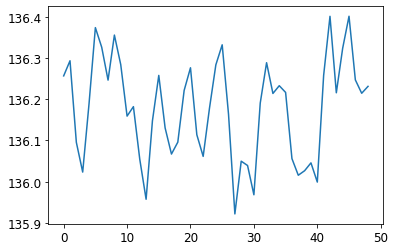

In [67]:
df['B10-2'].plot()

In [68]:
headfile = '{}.hds'.format(ml_name)
fname = os.path.join(tmp_model_ws, headfile)
hds = flopy.utils.binaryfile.HeadFile(fname)
h = hds.get_data()

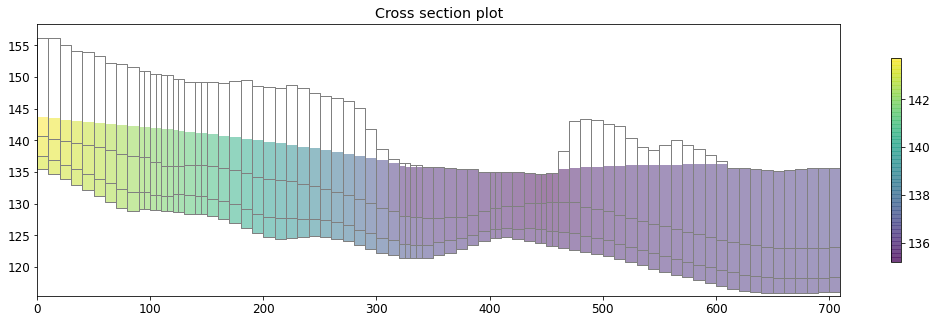

In [69]:
fig = plt.figure(figsize=(18, 5))
ax = fig.add_subplot(1, 1, 1)
ax.set_title("Cross section plot")

xsection = np.array([(427000, 6654690), (427540, 6655230)])
xsect = flopy.plot.PlotCrossSection(model=gwf, line={"line": xsection})
patch_collection = xsect.plot_array(h, head=h, alpha=0.5)
line_collection = xsect.plot_grid()
cb = plt.colorbar(patch_collection, shrink=0.75)

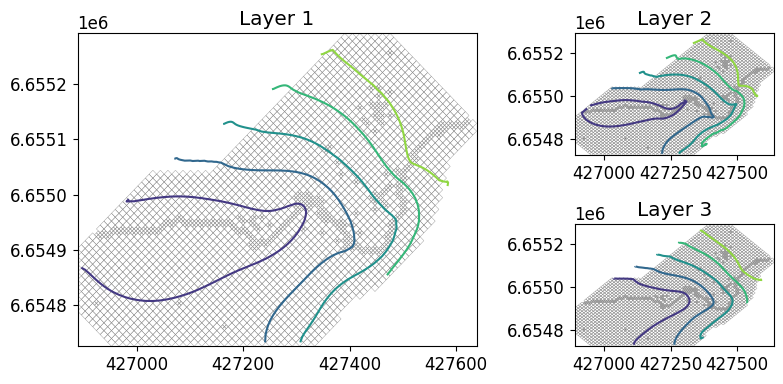

In [70]:
fig = plt.figure(figsize=(8,4), dpi=100)

axs = fig.subplot_mosaic([['Left', 'TopRight'],['Left', 'BottomRight']],
                          gridspec_kw={'width_ratios':[2, 1]})

axs['Left'].set_title('Layer 1')
axs['TopRight'].set_title('Layer 2')
axs['BottomRight'].set_title('Layer 3')

for index, ax in enumerate(axs):
    modelmap = flopy.plot.PlotMapView(model=gwf, ax=axs[ax])
    linecollection = modelmap.plot_grid(lw=0.25)
    contours = modelmap.contour_array(h[index])
    
plt.tight_layout()
plt.show()

In [71]:
#Check the budget
mf_list = flopy.utils.Mf6ListBudget(os.path.join(tmp_model_ws, f"{gwf.name}.lst"), timeunit='days') #MF6ListBudget is different from MfListBudget...*sigh*
incremental, cumulative = mf_list.get_budget()
incrementaldf, cumulativedf = mf_list.get_dataframes(start_datetime="01-09-2017")

incrementaldf

,STO-SS_IN,STO-SY_IN,GHB_IN,RCH_IN,SFR_IN,TOTAL_IN,STO-SS_OUT,STO-SY_OUT,GHB_OUT,RCH_OUT,SFR_OUT,TOTAL_OUT,IN-OUT,PERCENT_DISCREPANCY
2017-01-10,0.0,0.0,30524.183594,0.000000,3605.204102,34129.386719,0.000000,0.0000,633.405273,0.0,33495.968750,34129.375000,0.013906,0.0
2021-01-09,0.0,0.0,29694.144531,639.990784,3661.516602,33995.652344,0.012815,16.5833,687.641479,0.0,33291.414062,33995.652344,0.000193,0.0


---

In [72]:
# Some "pre-history matching" plots:
olproc_in = os.path.join('..', 'data', 'olproc_input')
os.listdir(olproc_in)

['accumulated_eosine.ssf',
 'accumulated_fluorescein.ssf',
 'accumulated_rwt.ssf',
 'accumulated_srb.ssf',
 'dh-head-stage1.ssf',
 'obs-gage1.ssf',
 'obs-head1.ssf',
 'obs-head2.ssf',
 'obs-head3.ssf',
 'obs-stage1.ssf',
 'readme.md']

In [73]:
measured_gage = pyemu.utils.smp_utils.smp_to_dataframe(os.path.join(olproc_in, 'obs-gage1.ssf'))
computed_gage = pd.read_csv(os.path.join(tmp_model_ws, 'sfr_gage.obs.csv'))

In [74]:
computed_gage['datetime'] = pd.Timestamp('2015-12-31') + pd.to_timedelta(computed_gage['time'], 'D')

In [75]:
computed_gage = pd.melt(computed_gage[['datetime', 'GAGE-1', 'GAGE-2']], id_vars=['datetime'])

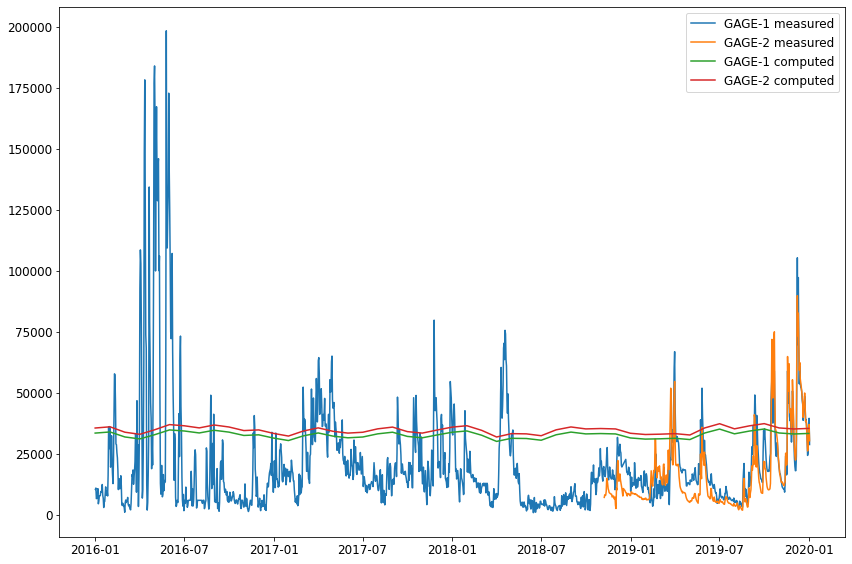

In [76]:
fig, ax = plt.subplots(1, 1, figsize=(12,8))

for gage in measured_gage.name.unique():
    gagedata = measured_gage.loc[measured_gage['name'] == gage]
    x, y, = gagedata.datetime, gagedata.value
    ax.plot(x, y, label=gage+' measured')

for gage in computed_gage.variable.unique():
    gagedata = computed_gage.loc[computed_gage['variable'] == gage]
    x, y, = gagedata.datetime, gagedata.value
    ax.plot(x, y, label=gage+' computed')

plt.legend()
plt.tight_layout()

In [77]:
# Plot reach leakage

In [78]:
computed_leakage = pd.read_csv(os.path.join(tmp_model_ws, 'sfr_leak.obs.csv'))

In [79]:
computed_leakage

,time,LEAK-1,LEAK-2,LEAK-3,LEAK-4,LEAK-5,LEAK-6,LEAK-7,LEAK-8,LEAK-9,...,LEAK-256,LEAK-257,LEAK-258,LEAK-259,LEAK-260,LEAK-261,LEAK-262,LEAK-263,LEAK-264,LEAK-265
0,1.000000,366.176363,107.815969,145.715200,183.795341,121.244814,111.124422,189.688116,14.263529,121.931623,...,-220.580389,-12.664697,-216.012787,-71.890597,-271.615484,-125.347024,-239.837633,-249.054867,-295.454104,-369.797913
1,31.416667,366.176346,107.815961,145.715182,183.795317,121.244798,111.124402,189.688081,14.263526,121.931586,...,-220.580694,-12.664718,-216.013045,-71.890710,-271.615705,-125.347152,-239.837799,-249.055070,-295.454233,-369.798126
2,61.833333,366.176345,107.815961,145.715181,183.795316,121.244798,111.124401,189.688080,14.263526,121.931584,...,-220.580703,-12.664719,-216.013052,-71.890714,-271.615712,-125.347156,-239.837804,-249.055077,-295.454237,-369.798132
3,92.250000,366.176345,107.815961,145.715181,183.795316,121.244798,111.124401,189.688080,14.263526,121.931584,...,-220.580704,-12.664719,-216.013054,-71.890714,-271.615713,-125.347157,-239.837805,-249.055077,-295.454238,-369.798133
4,122.666667,366.176345,107.815961,145.715181,183.795316,121.244798,111.124401,189.688080,14.263526,121.931584,...,-220.580705,-12.664719,-216.013055,-71.890715,-271.615714,-125.347157,-239.837806,-249.055078,-295.454238,-369.798134
5,153.083333,366.176345,107.815961,145.715181,183.795315,121.244798,111.124401,189.688079,14.263526,121.931584,...,-220.580706,-12.664719,-216.013055,-71.890715,-271.615714,-125.347157,-239.837806,-249.055079,-295.454239,-369.798135
6,183.500000,366.176345,107.815961,145.715181,183.795315,121.244798,111.124401,189.688079,14.263526,121.931584,...,-220.580707,-12.664719,-216.013056,-71.890715,-271.615715,-125.347158,-239.837807,-249.055079,-295.454239,-369.798135
7,213.916667,366.176345,107.815961,145.715181,183.795315,121.244798,111.124401,189.688079,14.263526,121.931584,...,-220.580708,-12.664719,-216.013057,-71.890716,-271.615715,-125.347158,-239.837807,-249.055080,-295.454239,-369.798136
8,244.333333,366.176345,107.815961,145.715181,183.795315,121.244797,111.124401,189.688079,14.263526,121.931583,...,-220.580709,-12.664719,-216.013058,-71.890716,-271.615716,-125.347158,-239.837808,-249.055080,-295.454240,-369.798136
9,274.750000,366.176345,107.815961,145.715181,183.795315,121.244797,111.124400,189.688079,14.263526,121.931583,...,-220.580709,-12.664719,-216.013058,-71.890716,-271.615717,-125.347159,-239.837808,-249.055081,-295.454240,-369.798137


In [80]:
quickstat = computed_leakage.describe()

In [81]:
quickstat

,time,LEAK-1,LEAK-2,LEAK-3,LEAK-4,LEAK-5,LEAK-6,LEAK-7,LEAK-8,LEAK-9,...,LEAK-256,LEAK-257,LEAK-258,LEAK-259,LEAK-260,LEAK-261,LEAK-262,LEAK-263,LEAK-264,LEAK-265
count,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,4.900000e+01,49.000000,...,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000
mean,731.000000,366.176345,107.815961,145.715181,183.795316,121.244798,111.124401,189.688080,1.426353e+01,121.931584,...,-220.580702,-12.664719,-216.013052,-71.890714,-271.615712,-125.347156,-239.837804,-249.055076,-295.454237,-369.798132
std,434.614326,0.000003,0.000001,0.000003,0.000004,0.000002,0.000003,0.000005,4.638091e-07,0.000006,...,0.000046,0.000003,0.000039,0.000017,0.000033,0.000019,0.000025,0.000031,0.000019,0.000032
min,1.000000,366.176345,107.815961,145.715181,183.795315,121.244797,111.124400,189.688079,1.426353e+01,121.931583,...,-220.580710,-12.664719,-216.013059,-71.890717,-271.615717,-125.347159,-239.837808,-249.055081,-295.454240,-369.798137
25%,366.000000,366.176345,107.815961,145.715181,183.795315,121.244797,111.124400,189.688079,1.426353e+01,121.931583,...,-220.580710,-12.664719,-216.013059,-71.890717,-271.615717,-125.347159,-239.837808,-249.055081,-295.454240,-369.798137
50%,731.000000,366.176345,107.815961,145.715181,183.795315,121.244797,111.124400,189.688079,1.426353e+01,121.931583,...,-220.580710,-12.664719,-216.013059,-71.890717,-271.615717,-125.347159,-239.837808,-249.055081,-295.454240,-369.798137
75%,1096.000000,366.176345,107.815961,145.715181,183.795315,121.244797,111.124400,189.688079,1.426353e+01,121.931583,...,-220.580710,-12.664719,-216.013059,-71.890717,-271.615717,-125.347159,-239.837808,-249.055081,-295.454240,-369.798137
max,1461.000000,366.176363,107.815969,145.715200,183.795341,121.244814,111.124422,189.688116,1.426353e+01,121.931623,...,-220.580389,-12.664697,-216.012787,-71.890597,-271.615484,-125.347024,-239.837633,-249.054867,-295.454104,-369.797913


In [82]:
y = [quickstat[i].values[1] for i in quickstat.columns[1:]]
x = range(len(y))

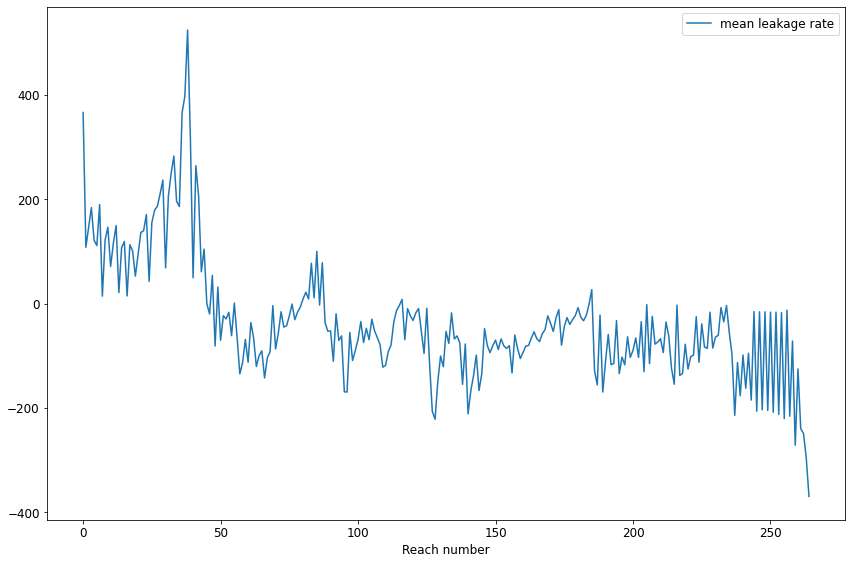

In [83]:
fig, ax = plt.subplots(1, 1, figsize=(12,8))

ax.plot(x, y, label='mean leakage rate')
ax.set_xlabel('Reach number')

plt.legend()
plt.tight_layout()

End of notebook

---

Delete LR to start over:

In [ ]:
#shutil.rmtree(lr_ws)